# Weighted Loss  : $(y-\hat{y})^\top (y-\hat{y})^\top \odot W$

## Import

In [67]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.family'] = 'NanumGothic'

import eptstgcn

In [68]:
class Loader(eptstgcn.DatasetLoader):
    def __init__(self,data_dict):
         self._dataset = data_dict 

## Data

In [69]:
# solar dataset
solar_ = pd.read_csv('./data2/restructuring_data.csv')
solar = solar_[['포항','대구','부산','경주시','청송군','서울','인천','수원','서산','창원']]
# solar = solar.drop('date', axis=1)

In [70]:
N = 10 # number of nodes
T = solar.shape[0]
node_ids = solar.columns.tolist()

In [71]:
FX_ = [solar.iloc[i,:] for i in range(T)]
FX = np.stack(FX_).tolist()

In [83]:
W = np.eye(N)
W[:(N-5),:(N-5)] = 1
W2 = np.eye(N)
W3 = np.array(solar.corr())

In [84]:
data_dict1={
    'edges':[[i,j] for i in range(N) for j in range(N)], 
    'node_ids': {node_ids[i]: i for i in range(N)}, 
    'weights':W.reshape(-1).tolist(),
    'FX':FX
}
data_dict2={
    'edges':[[i,j] for i in range(N) for j in range(N)], 
    'node_ids': {node_ids[i]: i for i in range(N)}, 
    'weights':W2.reshape(-1).tolist(), 
    'FX':FX
}
data_dict3={
    'edges':[[i,j] for i in range(N) for j in range(N)], 
    'node_ids': {node_ids[i]: i for i in range(N)}, 
    'weights':W3.reshape(-1).tolist(), 
    'FX':FX
}

## loader -> learn

In [86]:
dataset1 = Loader(data_dict1).get_dataset(lags=1)
dataset2 = Loader(data_dict2).get_dataset(lags=1)
train_dataset1, test_dataset1 = eptstgcn.utils.temporal_signal_split(dataset1, train_ratio = 0.9)
train_dataset2, test_dataset2 = eptstgcn.utils.temporal_signal_split(dataset2, train_ratio = 0.9)
lrnr1 = eptstgcn.WeightedLossStgcnLeaner(train_dataset1, dataset_name = 'ver1')
lrnr2 = eptstgcn.WeightedLossStgcnLeaner(train_dataset2, dataset_name = 'ver1')

In [33]:
lrnr1.learn(W,filters=2, epoch=30)
lrnr2.learn(W2,filters=2, epoch=30)

In [35]:
evaltor1 = eptstgcn.utils.Evaluator(lrnr1,train_dataset1,test_dataset1)
evaltor2 = eptstgcn.utils.Evaluator(lrnr2,train_dataset2,test_dataset2)

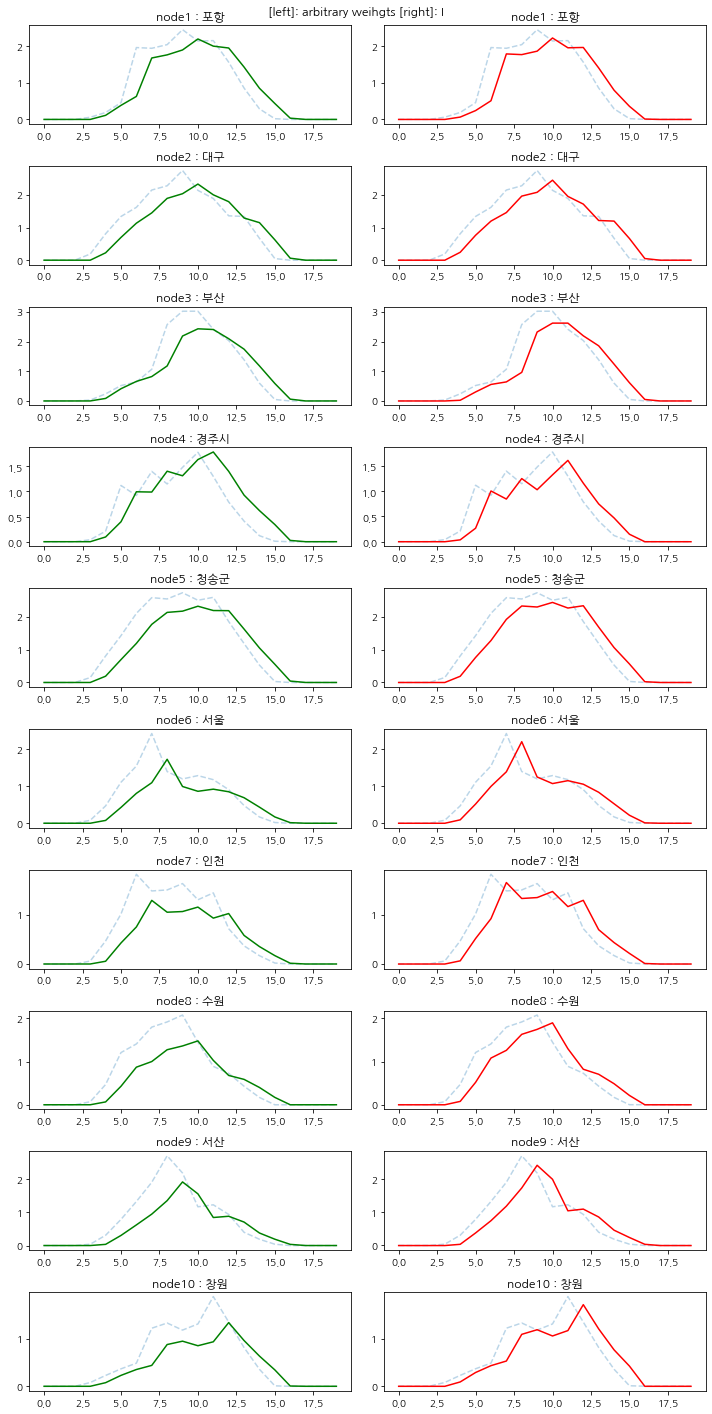

In [62]:
fig,axes = plt.subplots(N,2,figsize=(10,N*2))
n = 20
for i,ax in enumerate(axes): 
    ax[0].plot(evaltor1.f[-n:,i],'--',alpha=0.3)
    ax[1].plot(evaltor2.f[-n:,i],'--',alpha=0.3)
    ax[0].plot(evaltor1.fhat[-n:,i],'-', color='green')
    ax[1].plot(evaltor2.fhat[-n:,i],'-', color='red')
    ax[0].set_title('node{} : {}'.format(i+1,node_ids[i]))
    ax[1].set_title('node{} : {}'.format(i+1,node_ids[i]))
    plt.suptitle('[left]: arbitrary weihgts [right]: ')
    plt.tight_layout()

## Evaluation (test)

In [41]:
import torch

In [60]:
# w = arbitrary weight
lrnr1.model.eval()

cost = 0
for time, snapshot in enumerate(test_dataset1):
    y_hat = lrnr1.model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
    cost = cost + torch.mean((y_hat-snapshot.y)**2)
cost = cost / (time+1)
cost = cost.item()
print("MSE: {:.4f}".format(cost))

MSE: 0.2293


In [59]:
# w = identity matrix
lrnr2.model.eval()

cost = 0
for time, snapshot in enumerate(test_dataset1):
    y_hat = lrnr2.model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
    cost = cost + torch.mean((y_hat-snapshot.y)**2)
cost = cost / (time+1)
cost = cost.item()
print("MSE: {:.4f}".format(cost))

MSE: 0.2678


# Loss : $(y-\hat{y})^\top (y-\hat{y})$

> Weight : correlation

In [94]:
dataset3 = Loader(data_dict3).get_dataset(lags=1)
train_dataset3, test_dataset3 = eptstgcn.utils.temporal_signal_split(dataset3, train_ratio = 0.9)
lrnr3 = eptstgcn.StgcnLearner(train_dataset3, dataset_name = 'ver1')

In [95]:
lrnr3.learn(filters=2, epoch=30)

In [96]:
evaltor1 = eptstgcn.utils.Evaluator(lrnr3,train_dataset3,test_dataset3)

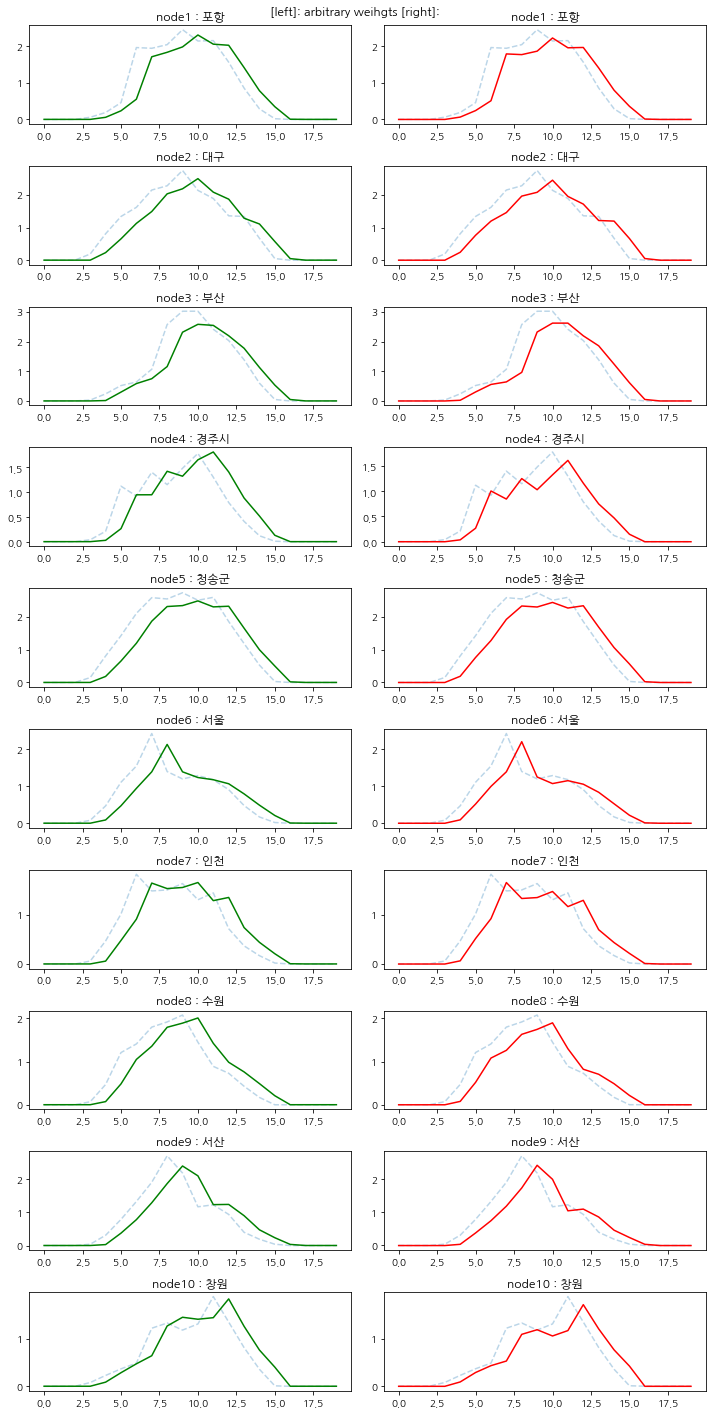

In [98]:
fig,axes = plt.subplots(N,2,figsize=(10,N*2))
n = 20
for i,ax in enumerate(axes): 
    ax[0].plot(evaltor1.f[-n:,i],'--',alpha=0.3)
    ax[1].plot(evaltor2.f[-n:,i],'--',alpha=0.3)
    ax[0].plot(evaltor1.fhat[-n:,i],'-', color='green')
    ax[1].plot(evaltor2.fhat[-n:,i],'-', color='red')
    ax[0].set_title('node{} : {}'.format(i+1,node_ids[i]))
    ax[1].set_title('node{} : {}'.format(i+1,node_ids[i]))
    plt.suptitle('[left]: arbitrary weihgts [right]: ')
    plt.tight_layout()

In [97]:
# w = arbitrary weight
lrnr3.model.eval()

cost = 0
for time, snapshot in enumerate(test_dataset1):
    y_hat = lrnr3.model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
    cost = cost + torch.mean((y_hat-snapshot.y)**2)
cost = cost / (time+1)
cost = cost.item()
print("MSE: {:.4f}".format(cost))

MSE: 0.2349
